In [1]:
# Read in packages

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import numpy as np
import glob

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve
import yaml 
import json

plt.style.use('physics.mplstyle')
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Define auxilary functions 

def get_limits(fn): # Returns quantile vs limits
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit]) 
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay="darkPho", path="./"): # Returns filename
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
     
def xs_scale(proc):
    xsec = 1.0
    with open(f"../config/xsections_{era}.json") as file:
            MC_xsecs = json.load(file)
    xsec  = MC_xsecs[proc]["xsec"] # Shouldn't I also multiply by this one --> will become evident!
    #xsec *= MC_xsecs[proc]["kr"]
    xsec *= MC_xsecs[proc]["br"]
    #xsec *= 1000.0
    assert xsec > 0, "{} has a null cross section!".format(proc)
    return xsec

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp




In [3]:
# Take temperature and mphi/mdark (in GeV) 
T = 2.0 
mdark = 2.0
era = 2018


# List of tuples with all phase space points (mdark,T) 
mdarks = np.array([1.4,2,3,4,8])
ratios = np.array([1/4,1/2,1,2,4])
tuples = []

for m in mdarks:
    for r in ratios:
        tuples.append((m,m*r))
        


In [4]:
# Get all SUEP masses for a given mdark and T

def get_params(mdark=mdark,T=T):

    # Get files
    combine_files = glob.glob("../higgs*.root")


    # Filter out the parameters
    all_params = []
    for file in combine_files:
        file_trim = file.split("HT1000_")[1]
        proc = 'GluGluToSUEP_HT1000_' + file_trim.split('.Asymptotic')[0]
        xsec = xs_scale(proc)
        t = float(file_trim.split("_")[0].replace("p",".")[1:])
        Mass = float(file_trim.split("_")[1][2:])
        mphi = float(file_trim.split("_")[2][4:])
        all_params.append([t,Mass,mphi,xsec])
    # print('all params',all_params[0:5])


    # Take params corresponding to mphi and Temperature
    params = []
    for pair in all_params:
        if pair[0] != T: continue
        if pair[2] != mdark: continue
        params.append([pair[1],pair[3]])
    # print('params', params)


    # check if combine produced the 5 expected limits
    skip_bad = []

    for pair in params:
        try:
            limit = get_limits(get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay="hadronic"))
            if limit.shape == (2,5):
                skip_bad.append(pair)
            else:
                print('Missing limits; ', get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay="hadronic"))
        except:
            print('No limits; ', get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay="hadronic"))

    return skip_bad


params = get_params()
    

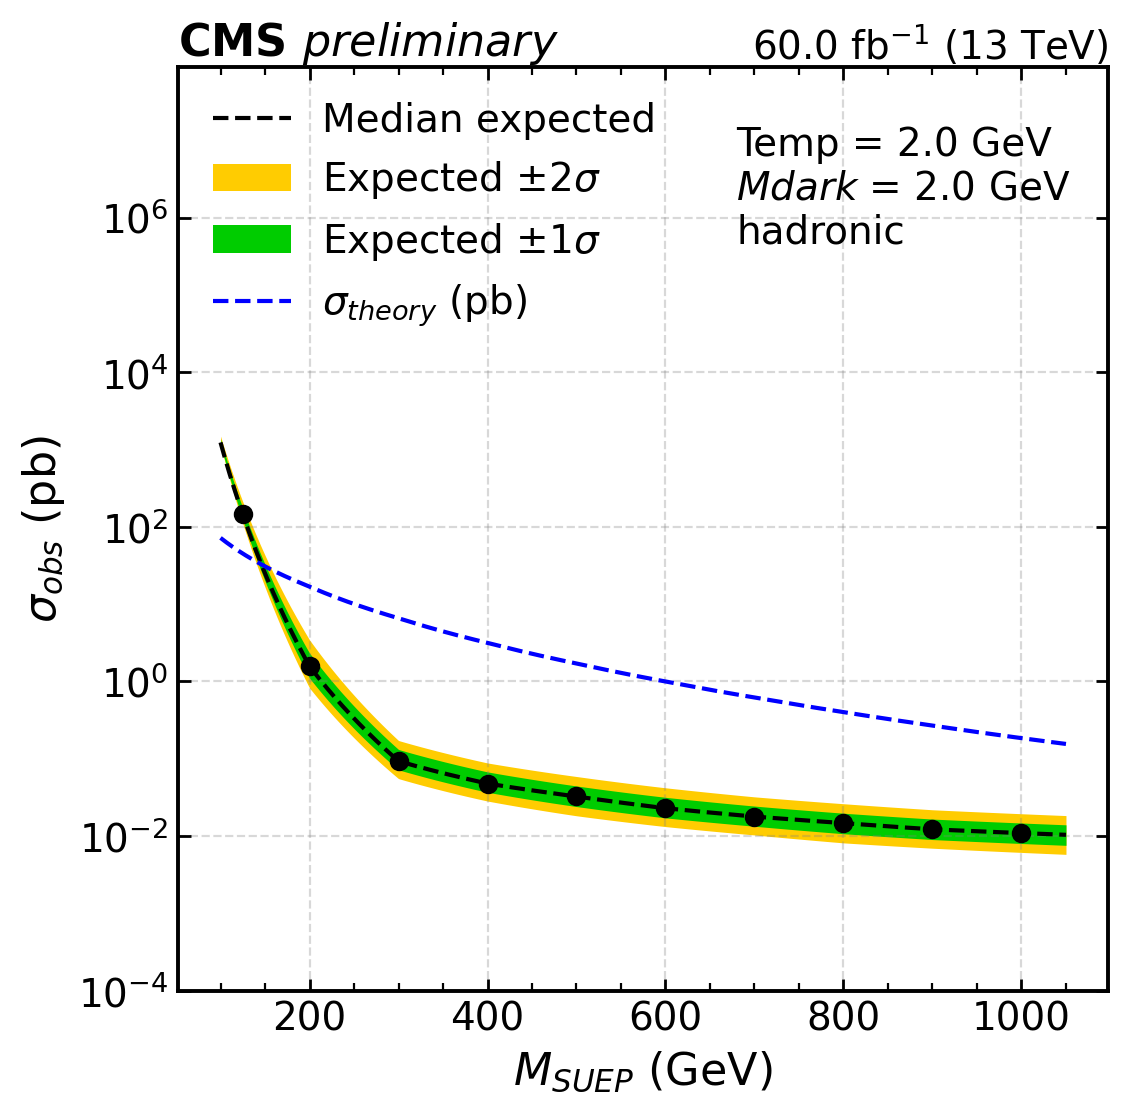

In [6]:
# Make brazil plot for all masses

def plot_dim_interpolate(params,decay="hadronic"):
    
    # Get data
    limits = []
    xsec = []
    masses = []
    
    for pair in params:
        if pair[0] not in masses: 
            masses.append(pair[0])
            xsec.append(pair[1])
        lims = get_limits(get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay=decay))
        lims = lims * pair[1]
        limits.append(lims)
        
            
    _exp = np.array([l[1][2] for l in limits])
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits]) 
    # _obs = np.array([l[1][5] for l in limits])    
    
    
    # Define interpolation
    exp_limit = log_interp1d(masses, _exp) 
    s1p_limit = log_interp1d(masses, _s1p)
    s1m_limit = log_interp1d(masses, _s1m)
    s2p_limit = log_interp1d(masses, _s2p)
    s2m_limit = log_interp1d(masses, _s2m)
    # obs_limit = log_interp1d(limitx, _obs)
    th_limit =  log_interp1d(masses, xsec)
    
    
    # Time to plot (mu Brazil plot, cross section Brazil plot)
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(masses, _exp,'.', ms=12, color='black')
    xvar = np.linspace(100,1050,1000)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")
    
    plt.plot(xvar,th_limit(xvar), #*.101,#* 0.101* 2/3,
             "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb)")

    # Just to make everything look nice
    plt.ylabel(r"$\sigma_{obs}$ (pb)")
    plt.xlabel(r"$M_{SUEP}$ (GeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    info = plt.text(
        0.6, 0.8, r"Temp = {} GeV""\n""$Mdark$ = {} GeV""\n""hadronic".format(T,mdark),
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.ylim(1e-4,9e7)
    plt.yscale("log")
    plt.savefig("/home/submit/pvanstee/public_html/SUEP/1D_brazil_plots_mar_10/SUEP_limits_T{}_mdark{}_{}.pdf".format(T,mdark,decay))
    plt.savefig("/home/submit/pvanstee/public_html/SUEP/1D_brazil_plots_mar_10/SUEP_limits_T{}_mdark{}_{}.png".format(T,mdark,decay))


    plt.show()
    
plot_dim_interpolate(params)



In [ ]:
for (mdark,T) in tuples:
    params = get_params(mdark, T)
    plot_dim_interpolate(params)